In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns

### 1. data preprorcessing: prepare data for training & test sets

#### import dataset and data cleaning and selection 

The training dataset includes wind speeds of various altitude increments, in 10 minutes intervals, for a little more than 12 month. It includes horizontal wind speed, vertical wind speed, mean values, max and min values in the increments, standard deviations and other columns. 

There are certain unrealistic values for wind speeds suh as 9999 or 9998 or N/A, this is likely due to processing error in the technical instrumet.

Thus, for data cleaning, we will filter out the values above 50 as it is nearly impossible for wind speed in the given altitudes to exceed 50. And for data selection, we shall only use the columns that record the horizontal wind speeds as the HAWTs (Horizontal-Axis Wind Turbines) use the lift force of the horizontal winds to generate energy, and disregard the other data for now.  

In [2]:
file_path = "../Data/E05_Hudson_South_West_10_min_avg_20220129_20230128.xls"

data = pd.read_excel(file_path)

data['timestamp'] = pd.to_datetime(data['timestamp'])

# Extract month, day, hour, and minute from the timestamp
data['month'] = data['timestamp'].dt.month
data['day'] = data['timestamp'].dt.day
data['hour'] = data['timestamp'].dt.hour
data['minute'] = data['timestamp'].dt.minute

# Sort the DataFrame by month, day, hour, and minute
data = data.sort_values(by=['month', 'day', 'hour', 'minute'])

# Optionally, drop the extracted columns if they are no longer needed
data.drop(['month', 'day', 'hour', 'minute'], axis=1, inplace=True)

# Reset the index after sorting (optional, but often useful)
data = data.reset_index(drop=True)

data.head()

,timestamp,lidar_lidar18m_Z10_HorizWS,lidar_lidar18m_Z10_StdDevWS,lidar_lidar18m_Z10_MaxWS,lidar_lidar18m_Z10_MinWs,lidar_lidar18m_WD_alg_03,lidar_lidar18m_Z10_VertWs,lidar_lidar18m_Z10_InfoFlag,lidar_lidar18m_Z10_StatFlag,lidar_lidar18m_Z10_Packets,...,AHRS_AHRSroll_Max,AHRS_AHRSroll_Min,AHRS_AHRSpitch_Max,AHRS_AHRSpitch_Min,AHRS_AHRSyaw_Max,AHRS_AHRSyaw_Min,buoy_status_CR6S_batt_Avg,buoy_status_GPSlat,buoy_status_GPSlong,FLS200_S/N
0,2023-01-01 00:00:00,7.3269,0.345,8.143,6.6933,221.7009,9998,36,0,27,...,4.995,-5.076,7.099,-6.121,2.986,-3.229,12.93,39.4851,-73.591,E05
1,2023-01-01 00:10:00,6.3896,0.3397,6.9518,5.7575,217.042,9998,36,0,31,...,4.152,-6.412,5.209,-6.512,2.5,-2.765,12.93,39.4851,-73.591,E05
2,2023-01-01 00:20:00,7.1015,0.3568,8.1623,6.5591,209.9876,9998,36,0,28,...,5.764,-6.225,5.8,-6.486,2.47,-4.338,12.93,39.4852,-73.591,E05
3,2023-01-01 00:30:00,5.9553,0.8678,7.1101,3.1298,205.8061,9998,36,0,23,...,4.465,-5.433,7.881,-5.817,2.532,-2.711,12.93,39.4851,-73.591,E05
4,2023-01-01 00:40:00,6.7674,0.7662,7.9653,5.2171,198.5833,9998,36,0,21,...,4.05,-5.951,6.942,-6.305,3.564,-3.775,12.93,39.4851,-73.591,E05


In [3]:
# Filtering columns with 'HorizWS' in their names
horiz_ws_columns = [col for col in data.columns if 'lidar_lidar138m_Z10_HorizWS' in col]
horiz_ws_data = data[horiz_ws_columns]

# Converting wind speed columns to numeric, setting errors='coerce' to turn non-numeric values into NaN
numeric_horiz_ws_data = horiz_ws_data.apply(pd.to_numeric, errors='coerce')

# Filtering out all values above 50
cleaned_numeric_horiz_ws_data = numeric_horiz_ws_data[numeric_horiz_ws_data <= 50].dropna()

# Displaying the first few rows of the cleaned numeric data
cleaned_numeric_horiz_ws_data.head()

,lidar_lidar138m_Z10_HorizWS
22,9.4720
23,10.9946
37,13.2145
38,12.2265
46,12.7887


#### Data normalization

The data is normalized with MinMax (imported from the scikit-learn library) for MinMax scaling's ability to transform data into a bounded range while preserving temporal relationships. It is suitable for TimeGAN models like this one, which are designed to generate realistic time-series data.

In [4]:
# Initializing the MinMaxScaler to scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fitting the scaler to the cleaned data and transforming it
normalized_data = scaler.fit_transform(cleaned_numeric_horiz_ws_data)

# Converting the normalized data back to a DataFrame for better readability
normalized_df = pd.DataFrame(normalized_data, columns=cleaned_numeric_horiz_ws_data.columns)

# Displaying the first few rows of the normalized data
normalized_df.head()

,lidar_lidar138m_Z10_HorizWS
0,0.265254
1,0.309856
2,0.374885
3,0.345943
4,0.362412


#### Reshaping the data

LSTM model is chosen to focus on seasonal variations so the previos

In [5]:
input_sequence_length = 144
output_sequence_length = 144

In [6]:
def create_sequences(data, history_length, forecast_length):
    X, Y = [], []
    for i in range(0, len(data) - history_length - forecast_length + 1, forecast_length):
        X.append(data[i:(i + history_length)])
        Y.append(data[(i + history_length):(i + history_length + forecast_length)])
    return np.array(X), np.array(Y)

In [7]:
X, Y = create_sequences(normalized_df, input_sequence_length, output_sequence_length)
training_ratio = 0.5
train_size = int(training_ratio * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

#### Defining the LSTM model

In [8]:
n_neurons = 256
activation = "relu"
num_epochs = 100
learning_rate = 0.005621897
minibatch_size = 64

In [9]:
model = Sequential()
model.add(LSTM(n_neurons, input_shape=(input_sequence_length, 1), return_sequences=True, activation = activation))
model.add(Dropout(0.2))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(output_sequence_length))

# Model compilation
model.compile(optimizer='adam', loss='mse')

# Model summary
model.summary()

early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 20, verbose = 1, restore_best_weights = True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 144, 64)           16896     
                                                                 
 dropout (Dropout)           (None, 144, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 144)               9360      
                                                                 
Total params: 59280 (231.56 KB)
Trainable params: 59280 (231.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
history = model.fit(X_train, Y_train, epochs = num_epochs, batch_size = minibatch_size, validation_data=(X_test, Y_test), callbacks=[early_stop])

Epoch 1/100
3/3 [==============================] - 4s 467ms/step - loss: 0.1199 - val_loss: 0.0806
Epoch 2/100
3/3 [==============================] - 1s 224ms/step - loss: 0.1145 - val_loss: 0.0752
Epoch 3/100
3/3 [==============================] - 1s 246ms/step - loss: 0.1063 - val_loss: 0.0655
Epoch 4/100
3/3 [==============================] - 1s 222ms/step - loss: 0.0915 - val_loss: 0.0468
Epoch 5/100
3/3 [==============================] - 1s 208ms/step - loss: 0.0685 - val_loss: 0.0399
Epoch 6/100
3/3 [==============================] - 1s 216ms/step - loss: 0.0571 - val_loss: 0.0282
Epoch 7/100
3/3 [==============================] - 1s 208ms/step - loss: 0.0447 - val_loss: 0.0232
Epoch 8/100
3/3 [==============================] - 1s 221ms/step - loss: 0.0401 - val_loss: 0.0198
Epoch 9/100
3/3 [==============================] - 1s 198ms/step - loss: 0.0352 - val_loss: 0.0196
Epoch 10/100
3/3 [==============================] - 1s 219ms/step - loss: 0.0318 - val_loss: 0.0170
Epoch 11/

In [11]:
def make_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

cwd = os.getcwd()
model_path = os.path.join(cwd, 'saved_model')
make_dir(model_path)
model.save(os.path.join(model_path, 'LSTM_model_new_1.h5'))

c:\Users\Jiarong Xie\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
model_path = os.path.join(os.getcwd(), 'saved_model', 'LSTM_model_new_1.h5')
lstm_model = load_model(model_path)

In [13]:
test_mse = lstm_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test MSE: {test_mse}")

Test MSE: 0.01455453597009182


In [14]:
train_size = int(training_ratio * len(cleaned_numeric_horiz_ws_data))
Y_test = cleaned_numeric_horiz_ws_data[train_size:]
Y_test = Y_test[:len(X_test) * len(X_test[0])]

In [15]:
y_pred = lstm_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

6/6 [==============================] - 1s 35ms/step


C:\Users\Jiarong Xie\AppData\Local\Temp\ipykernel_26268\2680432960.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Y_test, label='Actual Values', hist=True, color="green", kde=True, norm_hist=True)
C:\Users\Jiarong Xie\AppData\Local\Temp\ipykernel_26268\2680432960.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad637275

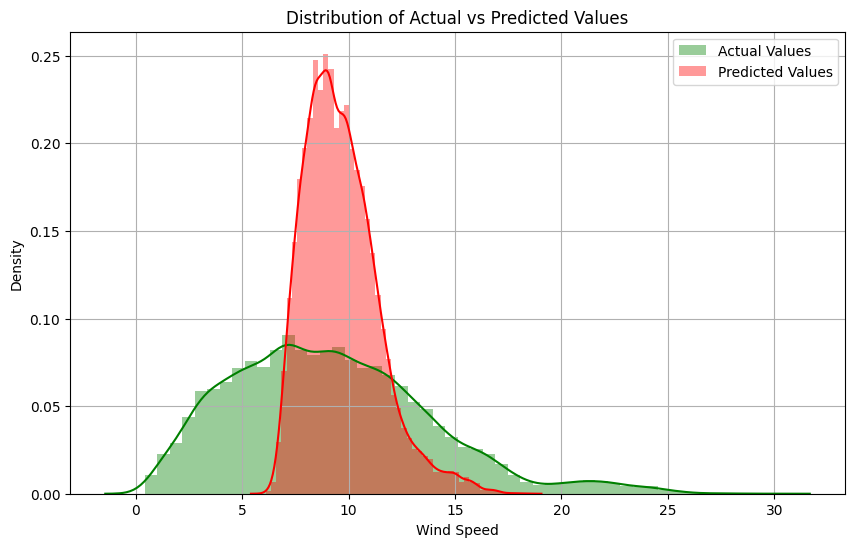

In [16]:
plt.figure(figsize=(10, 6))
#y_test_flat = Y_test.flatten()
y_pred_flat = y_pred.flatten()
sns.distplot(Y_test, label='Actual Values', hist=True, color="green", kde=True, norm_hist=True)
sns.distplot(y_pred_flat, label='Predicted Values', hist=True, color="red", kde=True, norm_hist=True)
plt.title('Distribution of Actual vs Predicted Values')
plt.xlabel('Wind Speed')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()

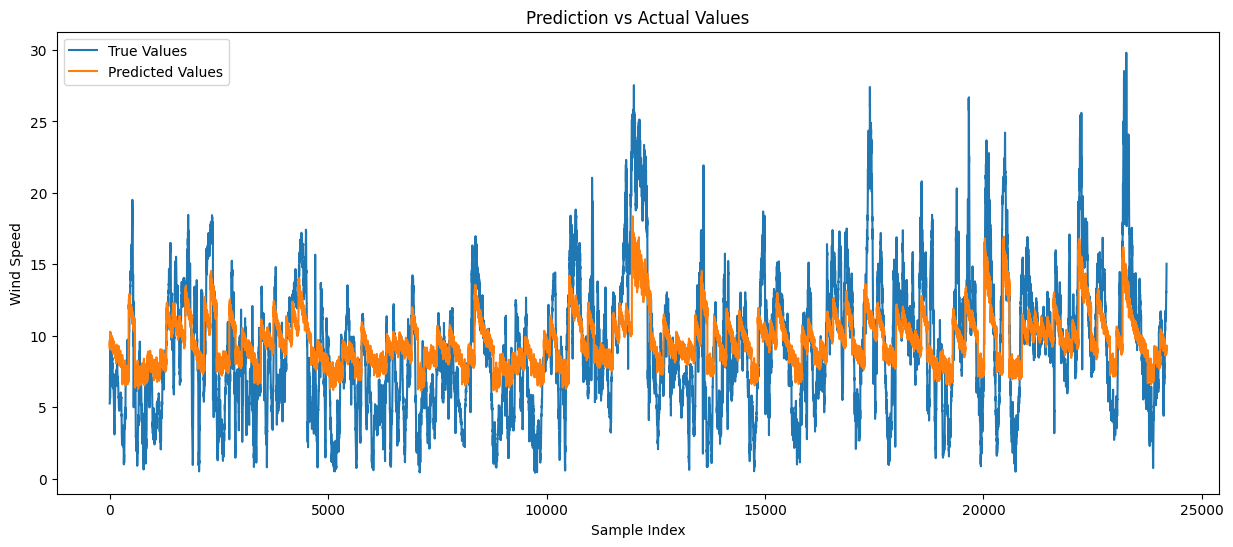

In [24]:
plt.figure(figsize=(15, 6))
plt.plot(Y_test.values, label='True Values')
plt.plot(y_pred_flat, label='Predicted Values')
plt.title('Prediction vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

In [18]:
def create_new_sequences(data, history_length, forecast_length, max_sequences=30):
    X, Y = [], []
    count = 0
    for i in range(0, len(data) - history_length - forecast_length + 1, history_length + forecast_length):
        if count >= max_sequences:
            break
        X.append(data[i:(i + history_length)])
        Y.append(data[(i + history_length):(i + history_length + forecast_length)])
        count += 1
    return np.array(X), np.array(Y)

# Assuming 'data' is your dataset
new_X_test, Y = create_new_sequences(normalized_df, input_sequence_length, 1, 30)

In [19]:
y_pred = lstm_model.predict(new_X_test)

1/1 [==============================] - 0s 51ms/step


In [21]:
# Assuming new_X_test is your initial input for the prediction
current_input = new_X_test

# This list will hold all predictions
all_predictions = []

for _ in range(1):  # Repeat the process 11 times
    # Predict the next 30 points
    next_predictions = lstm_model.predict(current_input)

    # Reshape next_predictions to match the dimensions of current_input
    # Assuming current_input is of shape (batch_size, time_steps, features)
    next_predictions_reshaped = next_predictions.reshape(current_input.shape[0], -1, current_input.shape[2])

    # Add the predictions to the list
    all_predictions.append(next_predictions)

    # Prepare the next input sequence:
    # Use the last prediction as the input for the next prediction
    current_input = np.append(current_input[:, 30:, :], next_predictions_reshaped, axis=1)

# all_predictions now contains 11 sets of 30-point forecasts

1/1 [==============================] - 0s 47ms/step


In [23]:
# Assuming all_predictions is a list of arrays
# Convert the list of arrays to a single 3D numpy array
all_predictions_array = np.concatenate(all_predictions, axis=0)

inversed_all_pred = scaler.inverse_transform(all_predictions_array)

y_pred_flat = inversed_all_pred.flatten()

In [32]:
data['month'] = data['timestamp'].dt.month

february_indices = data[data['month'] == 2].index

# Display the corresponding rows from 'cleaned_numeric_horiz_ws_data'
february_data = cleaned_numeric_horiz_ws_data.iloc[february_indices]

# Display the selected data
print(february_data)

       lidar_lidar138m_Z10_HorizWS
4984                       26.7750
4985                       27.4401
4986                       27.0147
4987                       27.6250
4988                       27.9269
...                            ...
9186                        5.6230
9187                        6.0500
9188                        6.1776
9189                        6.1977
9190                        6.1289

[4032 rows x 1 columns]


In [24]:
train_size = int(2/12 * len(cleaned_numeric_horiz_ws_data))
Y_test = cleaned_numeric_horiz_ws_data[train_size:]
Y_test = Y_test[:len(y_pred_flat)]

In [33]:
print(y_pred_flat.shape)
print(february_data.shape)

(4320,)
(4032, 1)


In [36]:
y_pred_flat

array([11.178765, 11.270139, 10.753285, ..., 11.079197,  9.068886,
        9.137048], dtype=float32)

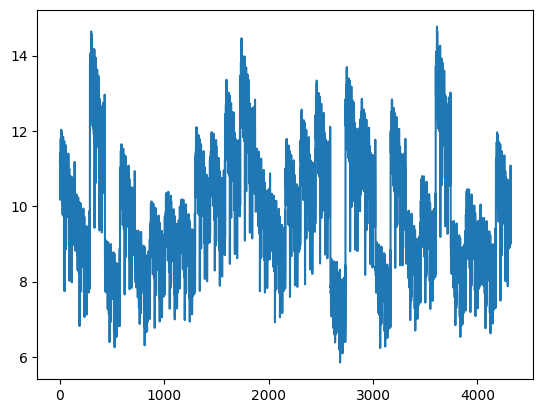

In [37]:
plt.plot(y_pred_flat, label='Predicted Values')

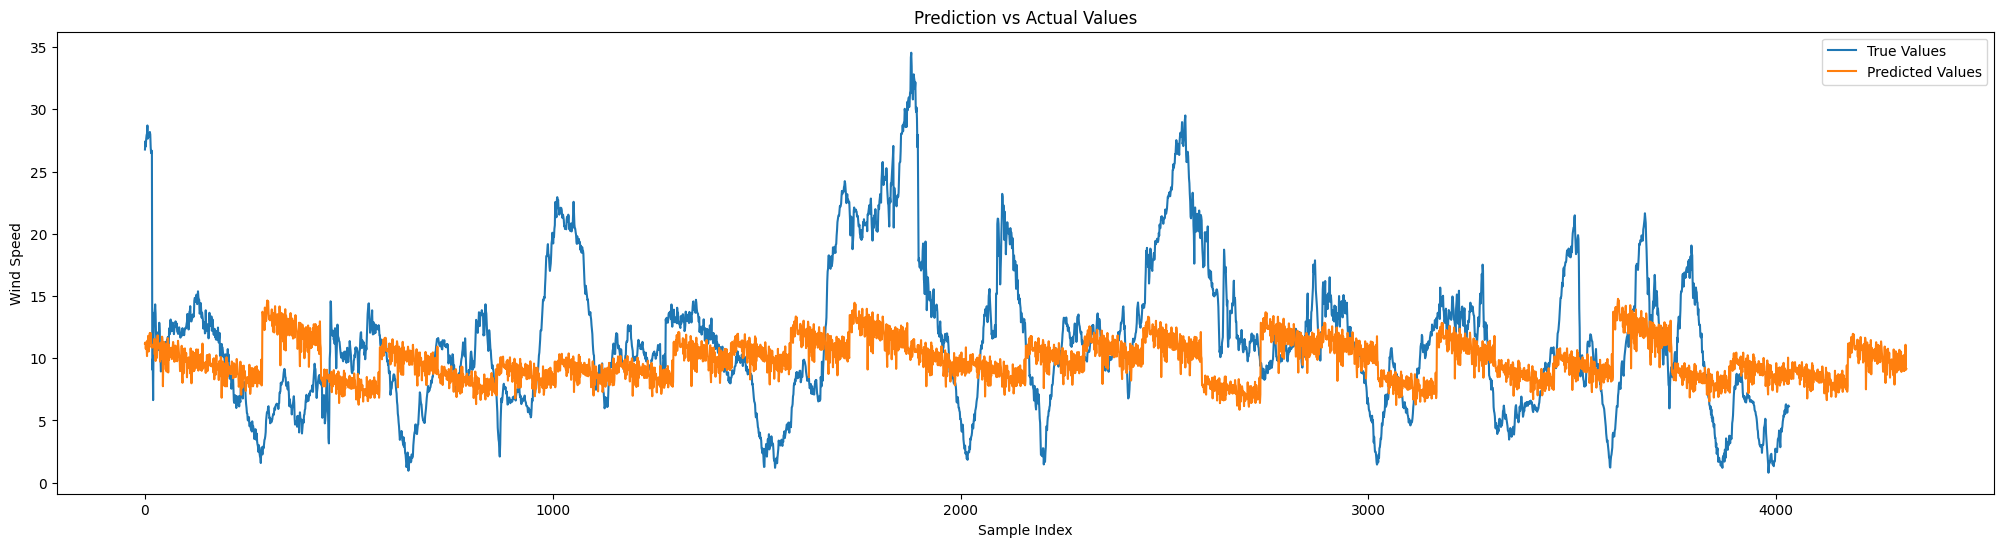

In [34]:
plt.figure(figsize=(25, 6))
plt.plot(february_data.values, label='True Values')
plt.plot(y_pred_flat, label='Predicted Values')
plt.title('Prediction vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

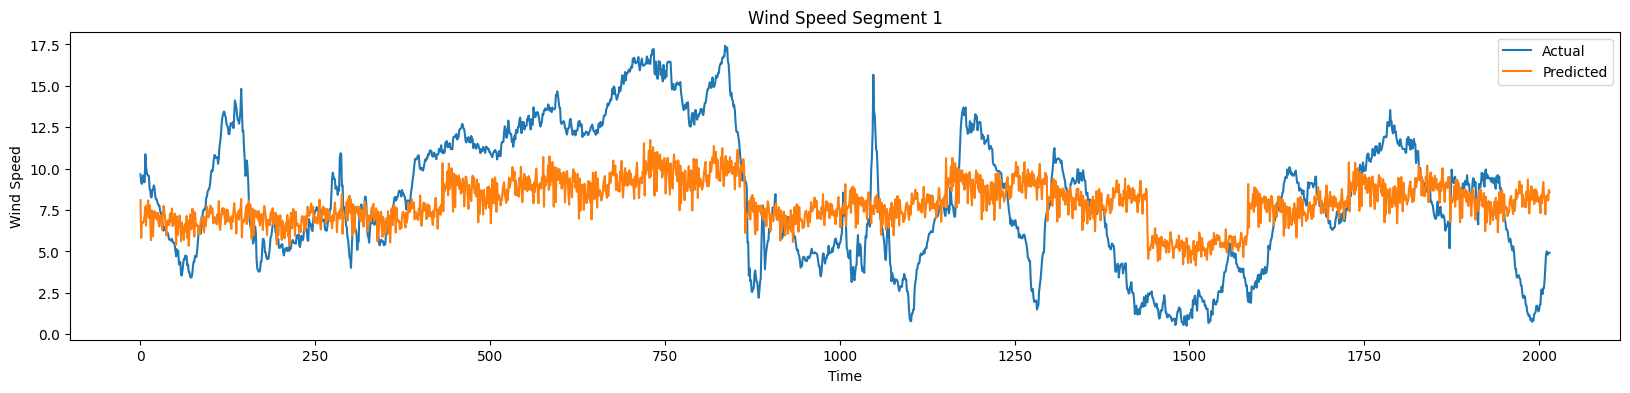

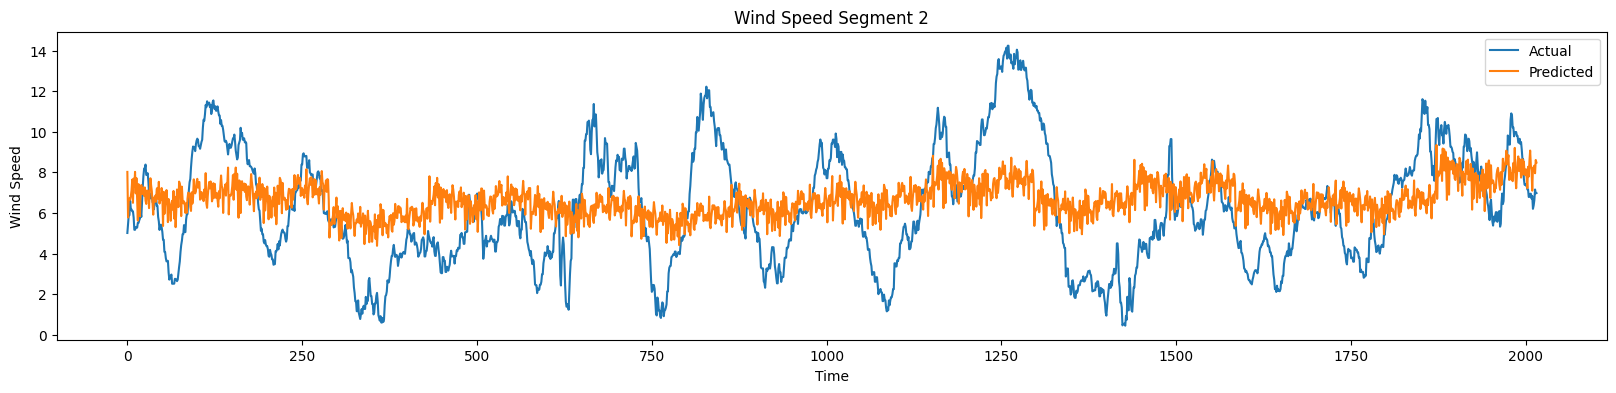

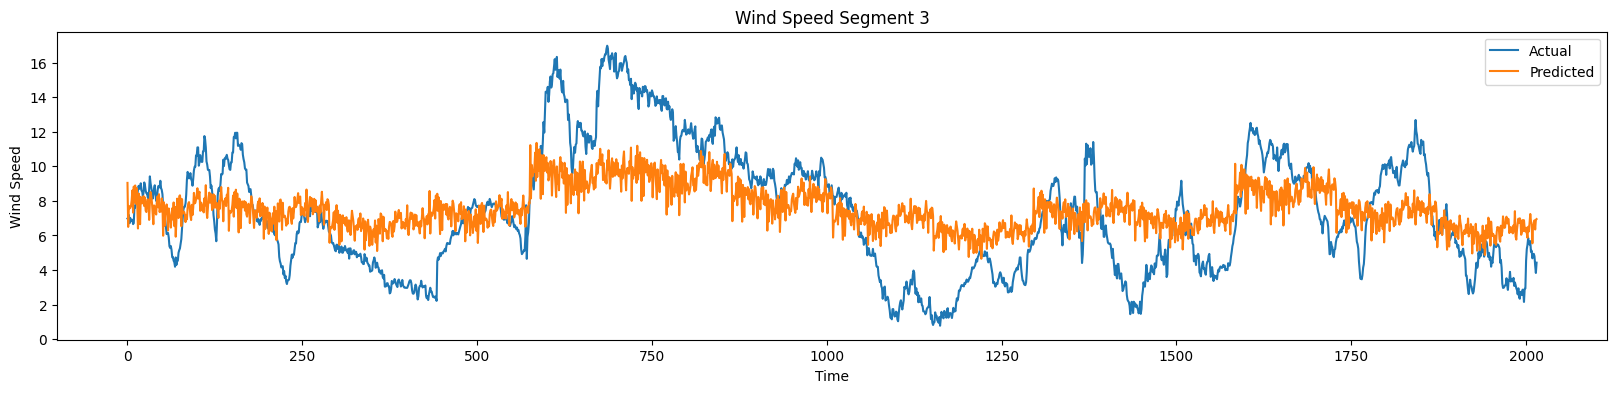

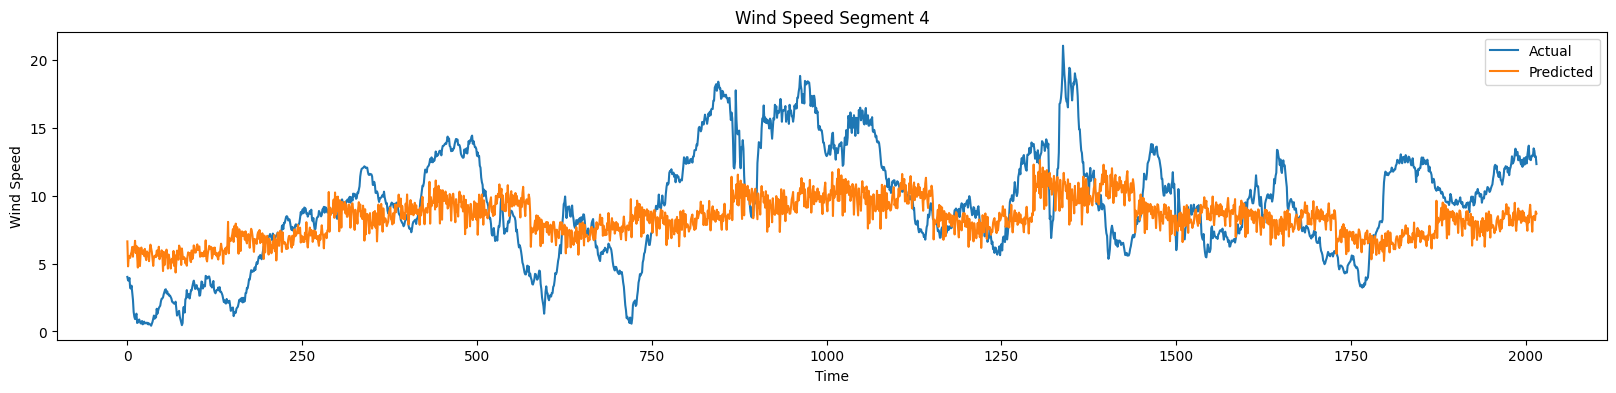

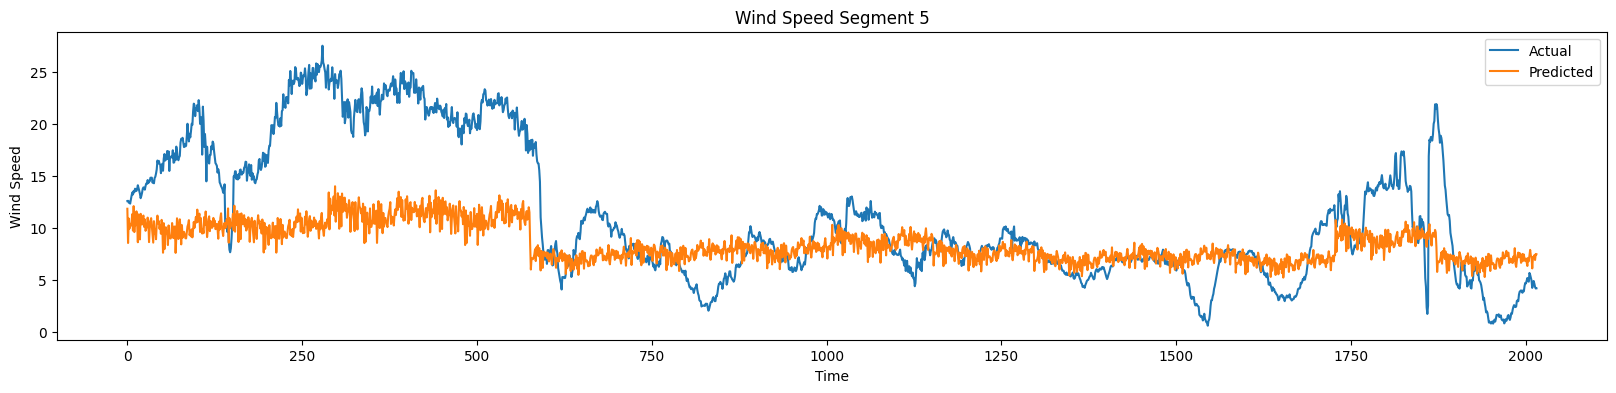

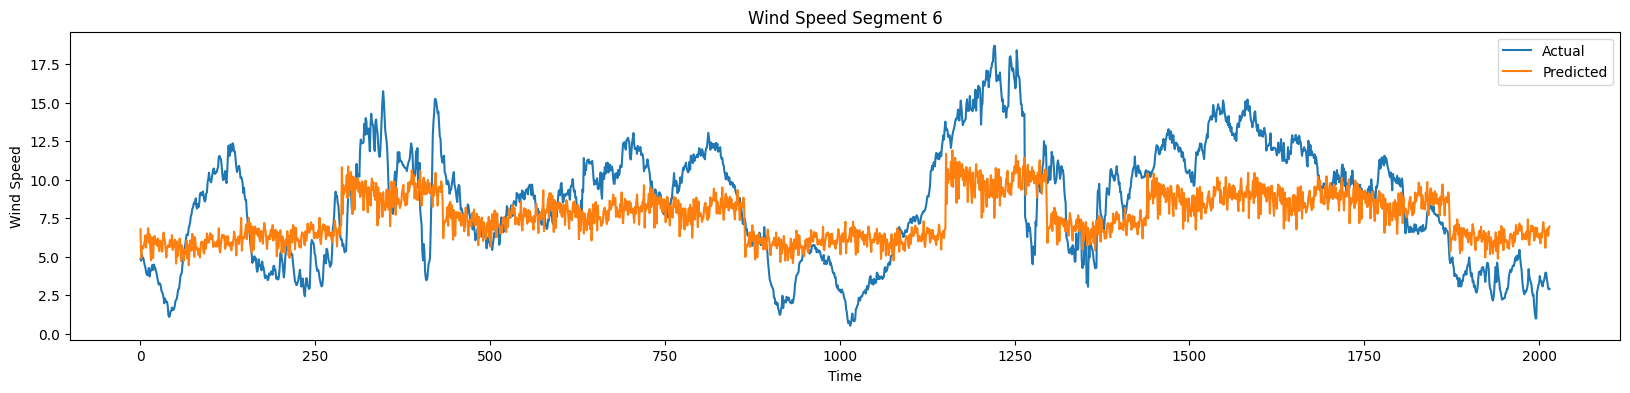

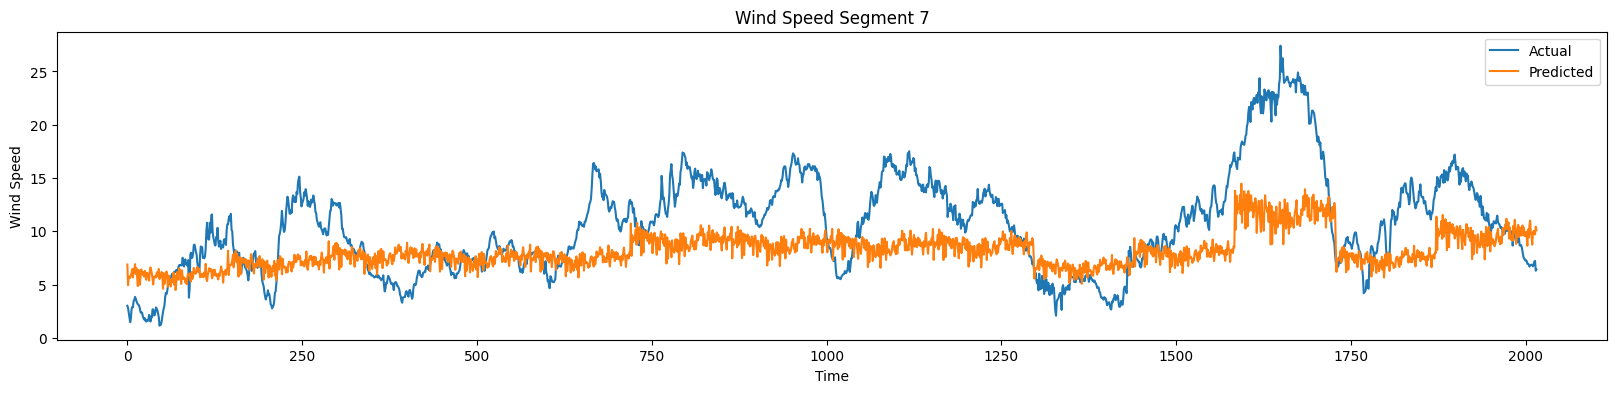

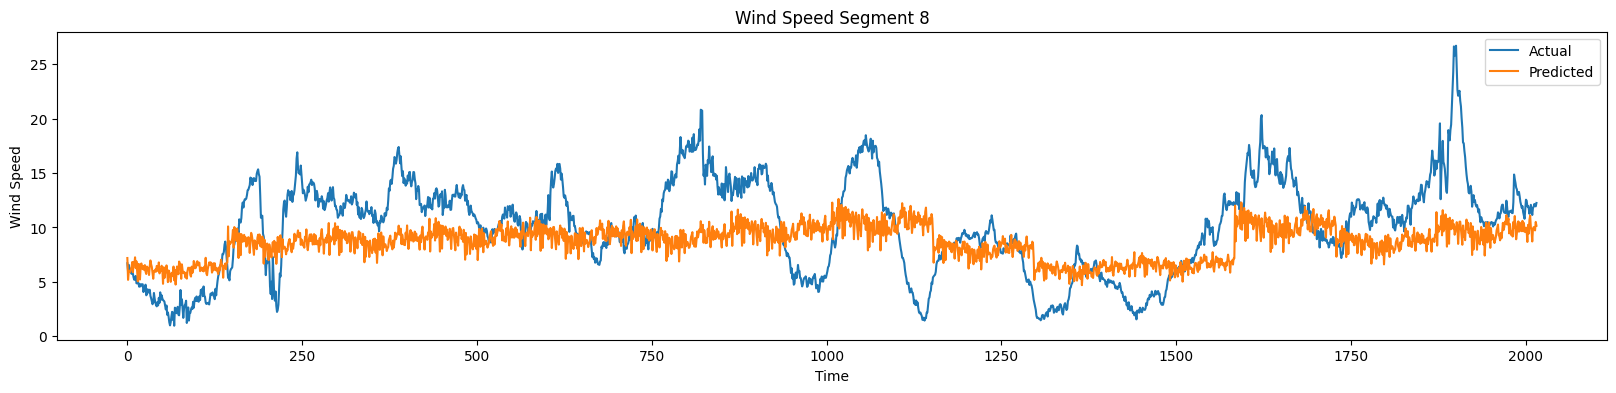

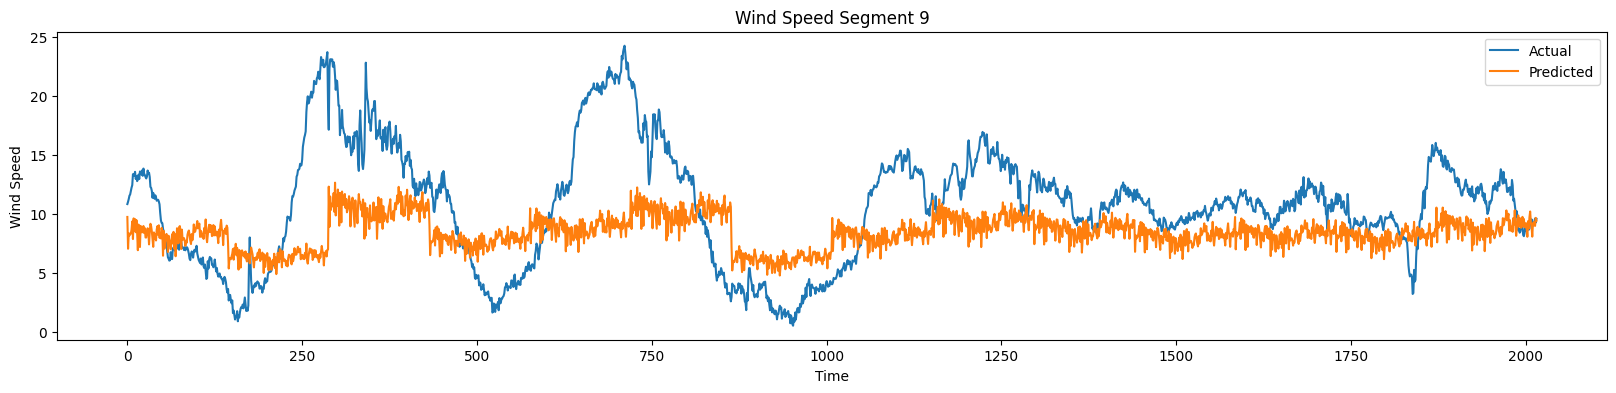

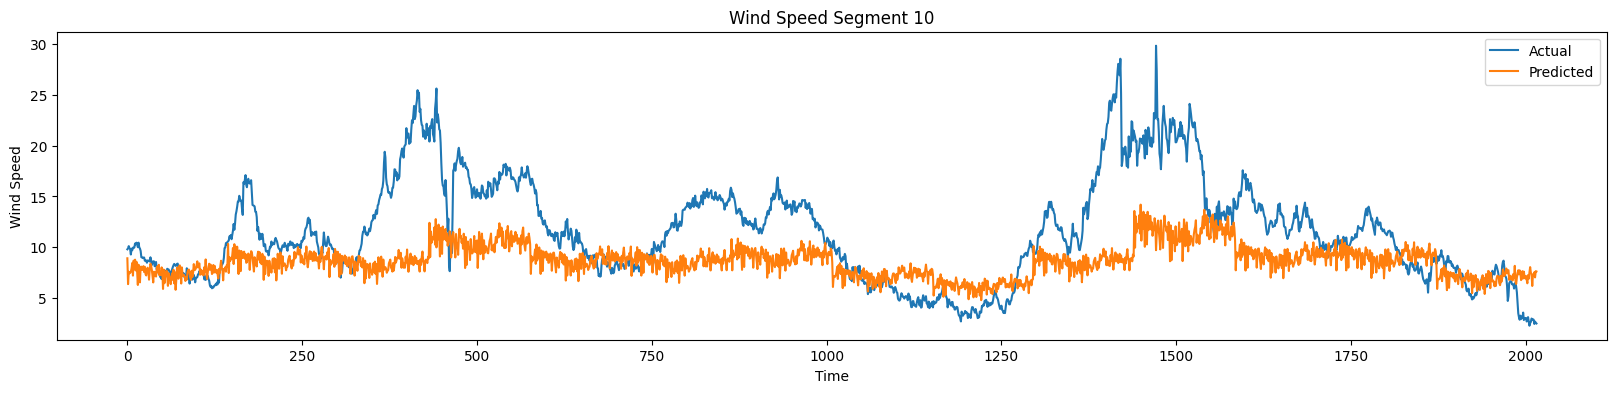

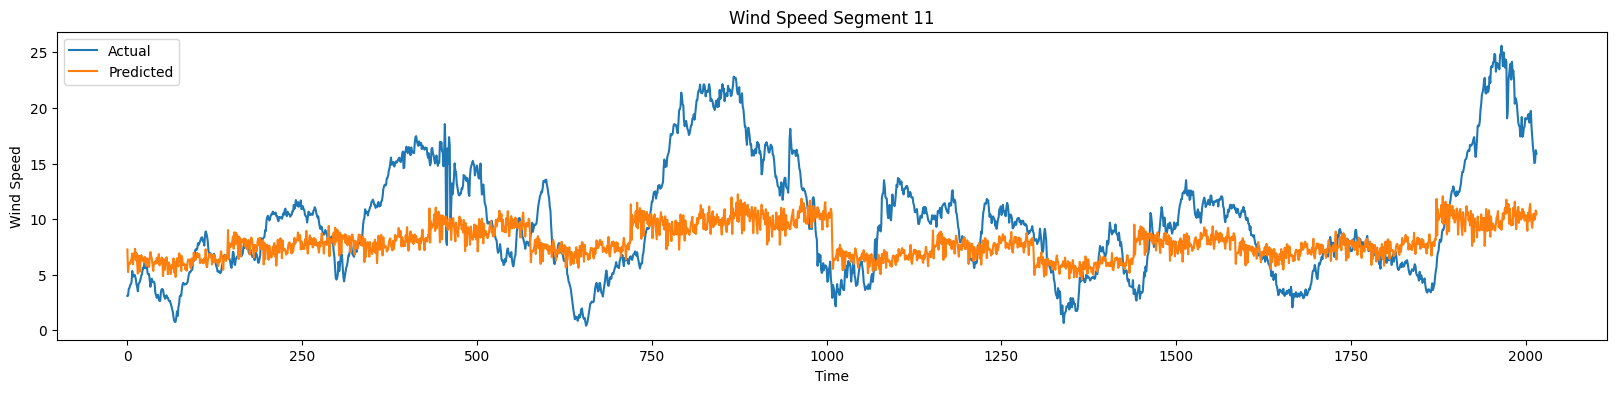

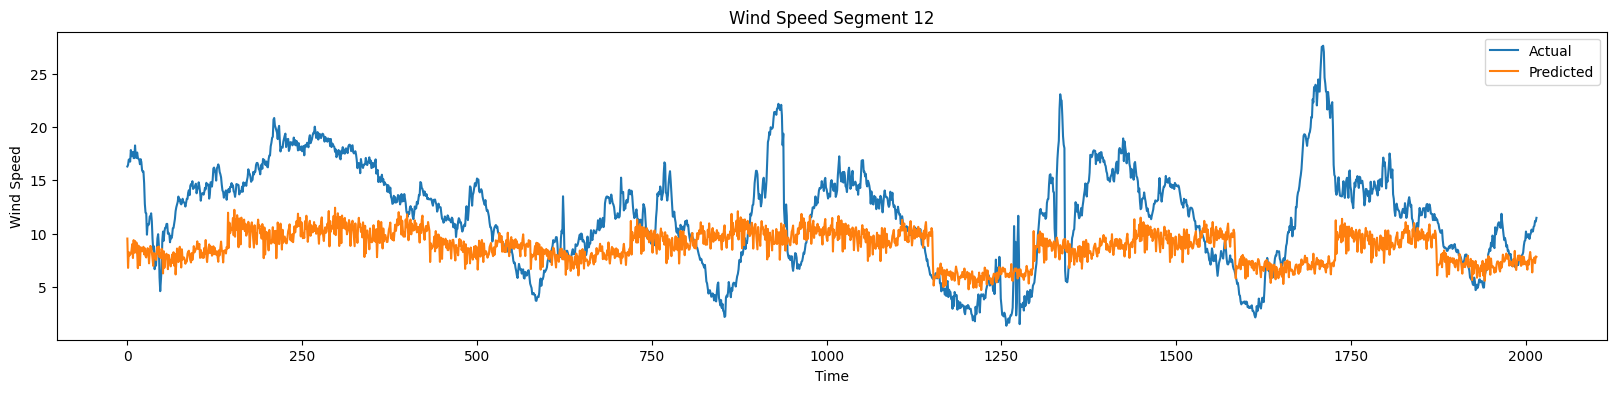

In [61]:
# Assuming y_test and y_pred are your actual and predicted values
num_plots = 12
total_points = len(Y_test)
points_per_plot = total_points // num_plots

for i in range(num_plots):
    plt.figure(figsize=(20, 4))  # Adjust the size as needed
    start_idx = i * points_per_plot
    end_idx = start_idx + points_per_plot

    plt.plot(Y_test.values[start_idx:end_idx], label='Actual')
    plt.plot(y_pred_flat[start_idx:end_idx], label='Predicted')
    plt.title(f'Wind Speed Segment {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Wind Speed')
    plt.legend()
    plt.show()